In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

['step', 'Monochromator-step', 'cps']


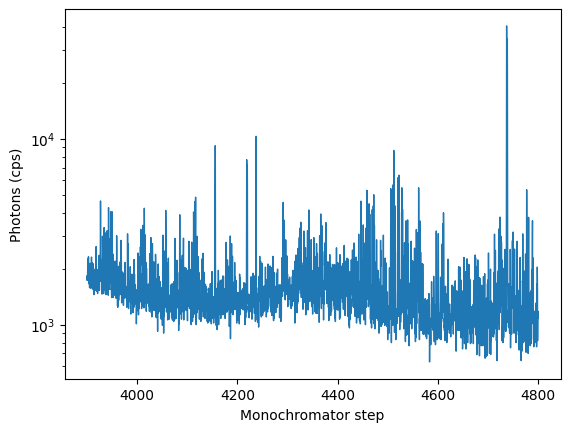

In [68]:
path =  "/Users/charlottemyers/projects/jlab/spectro/data/Nate_Charlotte_1001_Run3.txt"
df = pd.read_csv(path, sep=r"\s+")
#df = df.iloc[:, [1, 2]].rename(columns={df.columns[0]: "step", df.columns[1]: "cps"})
print(df.columns.tolist())
# step = df["Monochromator-step"].to_numpy()
# cps  = df["cps"].to_numpy()
step = df["Monochromator-step"].to_numpy()
cps  = df["cps"].to_numpy()

plt.plot(step, cps, lw=1, label = path.split("/")[-1])
plt.xlabel("Monochromator step")
plt.ylabel("Photons (cps)")
plt.yscale("log")
#plt.xlim(6420, 6450)

peak location 1: 6431.463656344028
Fit parameters: [ 9.25822746e+04  6.43146366e+03  1.44484962e-01  1.71383865e-01
 -1.39349306e+04 -9.90585232e+03]


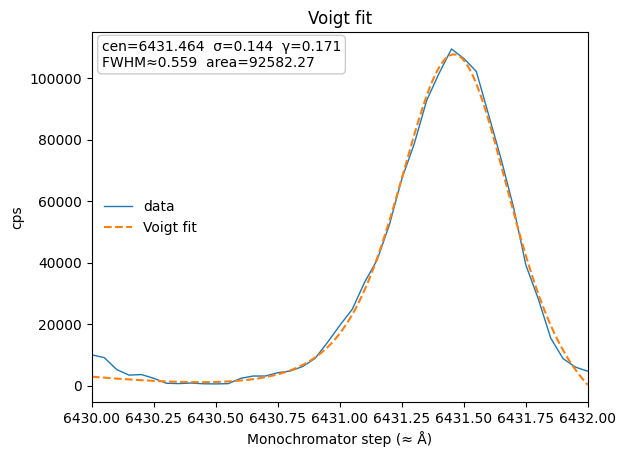

In [40]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Normalized Voigt (unit area).
def _voigt_norm(x, cen, sigma, gamma):
    z = ((x - cen) + 1j*gamma) / (sigma*np.sqrt(2))
    return np.real(wofz(z)) / (sigma*np.sqrt(2*np.pi))

# Model: area*Voigt + linear baseline
def voigt_model(x, area, cen, sigma, gamma, b0, b1):
    return area * _voigt_norm(x, cen, sigma, gamma) + (b0 + b1*(x - cen))

def fit_voigt_peak(step, cps, x0_rough, window=5.0, use_weights=True):
    # --- window data around the line ---
    m = (step >= x0_rough - window) & (step <= x0_rough + window)
    x, y = step[m].astype(float), cps[m].astype(float)

    # --- initial guesses ---
    cen0 = x[np.argmax(y)]
    ylo  = np.percentile(y, 10)
    yhi  = y.max()
    hm   = ylo + 0.5*(yhi - ylo)
    try:
        iL = np.where(y >= hm)[0][0]
        iR = np.where(y >= hm)[0][-1]
        fwhm0 = max( (x[iR] - x[iL]), 1e-3 )
    except Exception:
        fwhm0 = max(0.8, (x.max()-x.min())/6)  # fallback
    sigma0 = max(fwhm0/2.355, 1e-3)
    gamma0 = 0.5*sigma0
    area0  = max((yhi - ylo) * sigma0 * np.sqrt(2*np.pi), 1e-6)
    b0_0, b1_0 = float(ylo), 0.0

    p0 = [area0, cen0, sigma0, gamma0, b0_0, b1_0]
    bounds = (
        [0.0, cen0 - window, 1e-6, 1e-6, -np.inf, -np.inf],
        [np.inf, cen0 + window, window*2.0,  window*2.0,  np.inf,  np.inf],
    )

    sigma_y = None
    if use_weights:
        sigma_y = np.sqrt(np.clip(y, 1.0, None))  # Poisson-ish
    popt, pcov = curve_fit(
        voigt_model, x, y, p0=p0, bounds=bounds,
        sigma=sigma_y, absolute_sigma=True, maxfev=20000
    )
    area, cen, sigma, gamma, b0, b1 = popt

    # Approx Voigt FWHM (Olivero-Longbothum)
    fwhm = 0.5346*(2*gamma) + np.sqrt(0.2166*(2*gamma)**2 + (2.355*sigma)**2)

    # Plot
    xf = np.linspace(x.min(), x.max(), 1000)
    yf = voigt_model(xf, *popt)
    plt.plot(x, y, lw=1, label="data")
    plt.plot(xf, yf, ls="--", label="Voigt fit")

    # annotate
    txt = (f"cen={cen:.3f}  σ={sigma:.3f}  γ={gamma:.3f}\n"
           f"FWHM≈{fwhm:.3f}  area={area:.2f}")
    plt.text(0.02, 0.98, txt, transform=plt.gca().transAxes,
             ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8"))
    plt.xlabel("Monochromator step (≈ Å)")
    plt.ylabel("cps")
    plt.legend(frameon=False)
    plt.title("Voigt fit")
    plt.xlim(x.min(), x.max())

    return popt, pcov, {"FWHM": fwhm}

# fit + plot
x0_rough = 6431.0
popt, pcov, extra = fit_voigt_peak(step, cps, x0_rough, window=1.0, use_weights=True)
peak_location1 = popt[1]
print("peak location 1:", peak_location1)
print("Fit parameters:", popt)

Peak location: 6429.677346120179


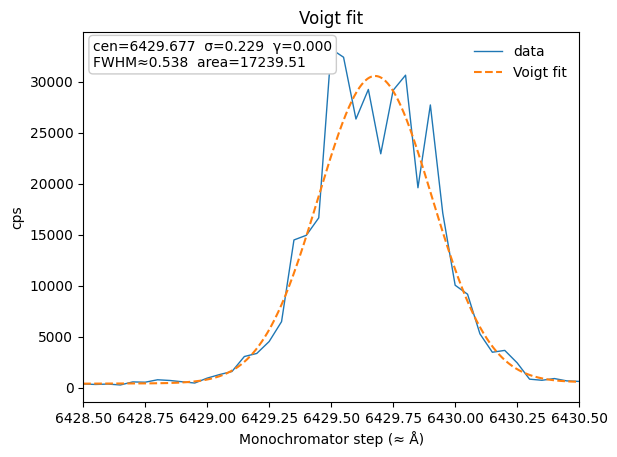

In [ ]:
# fit voigt to 2 adjacent peaks, extract the max as the peak centers
x0_rough = 6429.5
popt1, pcov1, extra1 = fit_voigt_peak(step, cps, x0_rough, window=1.0, use_weights=True)

peak_location2 = (popt1[1])
print("Peak location:", peak_location2)

In [41]:
delta_step = peak_location1 - peak_location2

In [ ]:
# def calibrate_quad(x, a, b, c):
#     return a* x**2 + b* x + c

# def calibrate(x, a, b):
#     return a*x + b

# quad_coeff = [4.64655929e-07, 9.99421690e-01, 1.15443650e+02]
# x_cal = calibrate_quad(step, *quad_coeff)

#import calibration function from calibration file
import pickle
with open("cal_functions.pkl", "rb") as f:
    cal = pickle.load(f)

print(cal["929"]["coeff"])

func = cal["929"]["function"]

x_cal = func(step)

[4.64655929e-07 9.99421690e-01 1.15443650e+02]
[6550.88234148 6550.93261087 6550.98288027 6551.03314967 6551.08341907
 6551.13368848 6551.18395788 6551.23422729 6551.2844967  6551.33476612
 6551.38503553 6551.43530495 6551.48557437 6551.53584379 6551.58611322
 6551.63638264 6551.68665207 6551.73692151 6551.78719094 6551.83746038
 6551.88772982 6551.93799926 6551.9882687  6552.03853815 6552.08880759
 6552.13907705 6552.1893465  6552.23961595 6552.28988541 6552.34015487
 6552.39042433 6552.4406938  6552.49096326 6552.54123273 6552.5915022
 6552.64177168 6552.69204115 6552.74231063 6552.79258011 6552.8428496
 6552.89311908 6552.94338857 6552.99365806 6553.04392755 6553.09419705
 6553.14446654 6553.19473604 6553.24500554 6553.29527505 6553.34554455
 6553.39581406 6553.44608357 6553.49635309 6553.5466226  6553.59689212
 6553.64716164 6553.69743116 6553.74770069 6553.79797022 6553.84823974
 6553.89850928 6553.94877881 6553.99904835 6554.04931789 6554.09958743
 6554.14985697 6554.20012652 655

In [49]:
delta_lambda = calibrate_quad(peak_location1, *quad_coeff) - calibrate_quad(peak_location2, *quad_coeff)
print("Delta lambda (A):", delta_lambda)
print("Expected delta lambda (A):", 0.17846254*10)

Delta lambda (A): 1.7959521823640898
Expected delta lambda (A): 1.7846254


In [ ]:
# find splitting between 2 peaks
mean_plateau = np.mean(cps[(x_cal > 6445)])
observed_peaks = x_cal[cps > mean_plateau + 0.1* np.std(cps)]
print(f"Observed peaks (steps) before averaging: {observed_peaks}")
print(len(observed_peaks))

Observed peaks (steps) before averaging: [6560.23249183 6560.28276166 6560.33303149 6560.38330132 6560.43357115
 6560.48384099 6560.53411083 6560.58438067 6560.63465051 6560.68492036
 6560.7351902  6560.78546005 6560.83572991 6560.88599976 6560.93626962
 6560.98653948 6561.03680934 6561.74058765 6561.79085755 6561.84112744
 6561.89139735 6561.94166725 6561.99193715 6562.04220706 6562.09247697
 6562.14274689 6562.1930168  6562.24328672 6562.29355664 6562.34382656
 6562.39409649 6562.44436641 6562.49463634 6562.54490627 6562.59517621
 6562.64544614 6562.69571608 6562.74598602 6562.79625596 6562.84652591
 6562.89679586 6562.94706581]
42
